# PowerCo Customer Churn – Feature Engineering & EDA Workflow

**Date:** August 3, 2025  
**Author:** Costas Pinto  
**Status:** Feature Engineering & Correlation Analysis Complete

---

## Step 1: Required Libraries & Configuration

To ensure scalability and maintainability, we started by importing necessary libraries and setting up a configuration class.

### Key Actions:
- Imported `pandas`, `numpy`, `matplotlib`, `seaborn`, and other utilities.
- Created a centralized `Config` class to manage:
  - Input/Output directories
  - Filenames
  - Key date columns
  - Snapshot date for relative calculations

### Directories Created:
- `datasets/` – Raw and cleaned input data
- `plots/` – Stores all generated visualizations
- `output/` – Stores feature-engineered datasets

---

In [ ]:
# --- Required Libraries ---
import os
import logging
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
class Config:
    """Centralized configuration for the entire notebook."""
    # Directories
    DATA_DIR = "datasets"
    OUTPUT_DIR = "output"
    PLOTS_DIR = "plots"
    
    # Filenames
    INPUT_DATA = "clean_data_after_eda.csv"
    PRICE_DATA = "price_data.csv"
    OUTPUT_DATA = "features_for_modeling.csv"
    
    # Key Columns & Parameters
    DATE_COLS = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']
    TARGET_COL = 'churn'
    SNAPSHOT_DATE = pd.to_datetime("2016-01-01")

# --- Initialization ---
config = Config()
os.makedirs(config.OUTPUT_DIR, exist_ok=True)
os.makedirs(config.PLOTS_DIR, exist_ok=True)
sns.set_theme(style="whitegrid")

print("Setup Complete: Configuration loaded and directories are ready.")

Setup Complete: Configuration loaded and directories are ready.


## Step 2: Data Loading

### Key Actions:
- Loaded cleaned customer dataset `clean_data_after_eda.csv`
- Loaded external pricing data `price_data.csv`
- Used robust error handling with assertions to ensure correct file path resolution
- Created a copy of the main dataframe (`after_df`) for transformations

---

In [2]:
def load_data(path: str) -> pd.DataFrame:
    """Loads data from a CSV file path with robust error handling."""
    assert os.path.exists(path), f"Data file not found at: {path}"
    print(f"Loading data from: {path}")
    return pd.read_csv(path)

# --- Load Datasets ---
try:
    before_df = load_data(os.path.join(config.DATA_DIR, config.INPUT_DATA))
    price_df = load_data(os.path.join(config.DATA_DIR, config.PRICE_DATA))
    
    # This copy will be transformed
    after_df = before_df.copy()
    
    print("\nData loaded successfully.")
except AssertionError as e:
    print(e)

Loading data from: datasets\clean_data_after_eda.csv
Loading data from: datasets\price_data.csv

Data loaded successfully.


## Step 3: Time-Based Feature Engineering

### Key Actions:
- Converted date columns (`date_activ`, `date_end`, etc.) to datetime objects
- Created new features:
  - `tenure_days` – Number of days between activation and contract end
  - `months_since_modif` – Time in months since last product modification

### Insights:
- `tenure_days` helps capture customer lifecycle
- `months_since_modif` may signal engagement recency or plan updates

---

In [4]:
print("--- Expanding Columns: Creating Time-Based Features ---")

# Convert date columns to datetime objects
for col in config.DATE_COLS:
    after_df[col] = pd.to_datetime(after_df[col], errors='coerce')

# Create new features
after_df['tenure_days'] = (after_df['date_end'] - after_df['date_activ']).dt.days

# CORRECTED LINE: Calculate difference in days, then divide to get months.
after_df['months_since_modif'] = ((config.SNAPSHOT_DATE - after_df['date_modif_prod']).dt.days / 30.4375).astype(int)

print("New features 'tenure_days' and 'months_since_modif' created.")

--- Expanding Columns: Creating Time-Based Features ---
New features 'tenure_days' and 'months_since_modif' created.


## Step 4: Price-Based Feature Engineering

### Key Actions:
- Parsed `price_date` in the pricing dataset
- Created features based on price changes and variability:
  - `price_diff_dec_jan_var`: Difference between December and January variable prices
  - `avg_price_var`: Average price over time for each customer
  - `std_price_var`: Standard deviation (volatility) of variable prices

### Merging:
- Merged these features with the main customer dataframe using `id` as the key

---

In [5]:
print("\n--- Combining Datasets: Creating Price-Based Features ---")

# Convert price_date to datetime
price_df['price_date'] = pd.to_datetime(price_df['price_date'], errors='coerce')

# 1. Create Estelle's Feature
monthly_prices = price_df.groupby(['id', price_df['price_date'].dt.month])['price_off_peak_var'].mean().unstack()
if 1 in monthly_prices.columns and 12 in monthly_prices.columns:
    monthly_prices['price_diff_dec_jan_var'] = monthly_prices[12] - monthly_prices[1]

# 2. Create Price Volatility & Average Features
agg_prices = price_df.groupby('id').agg(
    avg_price_var=('price_off_peak_var', 'mean'),
    std_price_var=('price_off_peak_var', 'std')
).reset_index()

# 3. Merge features back to the main dataframe
after_df = pd.merge(after_df, monthly_prices[['price_diff_dec_jan_var']], on='id', how='left')
after_df = pd.merge(after_df, agg_prices, on='id', how='left')

print("New price-based features created and merged.")


--- Combining Datasets: Creating Price-Based Features ---
New price-based features created and merged.


## Step 5: Consumption-Based Feature Engineering

### Key Actions:
- Calculated deviation of last month's consumption from the 12-month average
  - `cons_deviation_last_month = cons_last_month - (cons_12m / 12)`

### Insight:
- This feature may indicate unusual customer behavior just before churn (spike/drop in usage)

---

In [6]:
print("\n--- Combining Columns: Creating Consumption-Based Features ---")

# Calculate deviation of last month's consumption from the yearly average
avg_monthly_cons = after_df['cons_12m'] / 12
after_df['cons_deviation_last_month'] = after_df['cons_last_month'] - avg_monthly_cons

print("New feature 'cons_deviation_last_month' created.")


--- Combining Columns: Creating Consumption-Based Features ---
New feature 'cons_deviation_last_month' created.


## Step 6: Cleanup and Encoding

### Key Actions:
1. **Dropped redundant columns** such as:
   - Raw consumption (`cons_12m`, `cons_last_month`, etc.)
   - All original date columns
2. **Handled missing values** by filling with `0`
3. **Encoded categorical features**:
   - `channel_sales` and `origin_up` using one-hot encoding
   - Converted `has_gas` to binary (1 for 't', 0 for 'f')
4. **Set `id` as the index** (if available)

### Result:
- Final dataset is clean, encoded, and feature-rich

---

In [11]:
# 1. Remove redundant columns
cols_to_drop = config.DATE_COLS + ['cons_12m', 'cons_gas_12m', 'cons_last_month']
after_df = after_df.drop(columns=cols_to_drop, errors='ignore')
print(f"Dropped redundant columns.")

# 2. Clean and Encode
after_df = after_df.fillna(0)
if 'channel_sales' in after_df.columns and 'origin_up' in after_df.columns:
    after_df = pd.get_dummies(after_df, columns=['channel_sales', 'origin_up'])
if 'has_gas' in after_df.columns:
    after_df['has_gas'] = after_df['has_gas'].replace({'t': 1, 'f': 0}).astype(int)

# Add a check to see if 'id' is still a column before setting the index
if 'id' in after_df.columns:
    after_df = after_df.set_index('id')

print("Dataset finalized and ready for analysis.")

Dropped redundant columns.
Dataset finalized and ready for analysis.


In [12]:
def save_and_display_plot(fig: plt.Figure, filename: str, directory: str):
    """Saves a matplotlib figure and then displays it."""
    path = os.path.join(directory, filename)
    fig.savefig(path, bbox_inches='tight', dpi=150)
    print(f"Plot saved to: {path}")
    plt.show()

## Step 7: Correlation Heatmaps

###  Before Feature Engineering:
- Created a correlation matrix of the original dataset using numeric features
- Saved as: `before_correlation_heatmap.png`

###  After Feature Engineering:
- Selected engineered and key features:
  - `churn`, `tenure_days`, `net_margin`, `pow_max`, 
  - `price_diff_dec_jan_var`, `avg_price_var`, `std_price_var`, `cons_deviation_last_month`
- Created a new correlation heatmap to assess relationships with `churn`
- Saved as: `after_correlation_heatmap.png`

---

Plot saved to: plots\before_correlation_heatmap.png


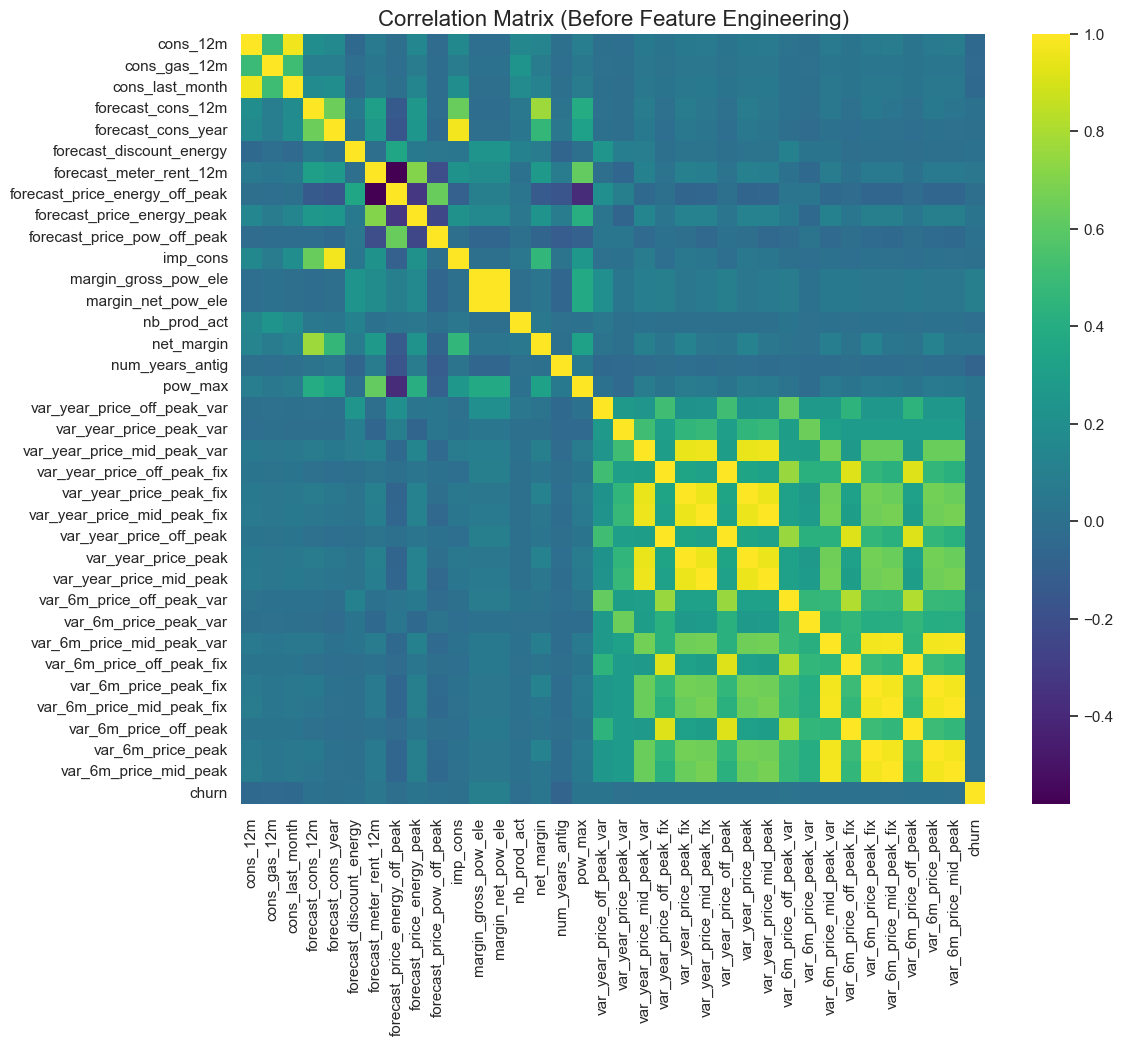

Plot saved to: plots\after_correlation_heatmap.png


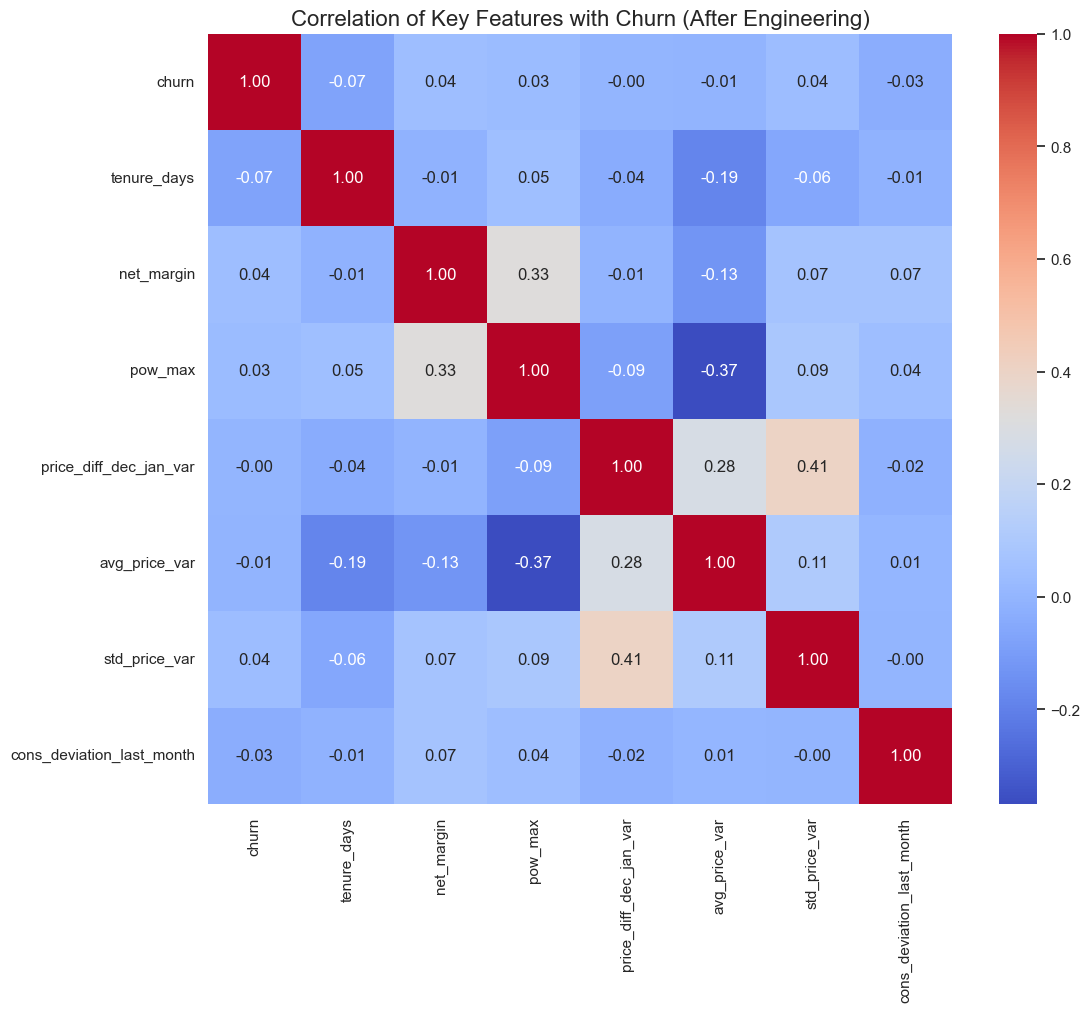

In [13]:
# --- Before ---
fig, ax = plt.subplots(figsize=(12, 10))
before_corr = before_df.select_dtypes(include=np.number).corr()
sns.heatmap(before_corr, annot=False, cmap='viridis', ax=ax)
ax.set_title('Correlation Matrix (Before Feature Engineering)', fontsize=16)
save_and_display_plot(fig, "before_correlation_heatmap.png", config.PLOTS_DIR)

# --- After ---
fig, ax = plt.subplots(figsize=(12, 10))
after_features_subset = [
    'churn', 'tenure_days', 'net_margin', 'pow_max', 
    'price_diff_dec_jan_var', 'avg_price_var', 'std_price_var', 'cons_deviation_last_month'
]
after_corr = after_df[after_features_subset].corr()
sns.heatmap(after_corr, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
ax.set_title('Correlation of Key Features with Churn (After Engineering)', fontsize=16)
save_and_display_plot(fig, "after_correlation_heatmap.png", config.PLOTS_DIR)

## Step 8: Targeted Visual Explorations

### Tenure vs. Churn
- Boxplot comparing `tenure_days` for churned vs. non-churned customers
- Saved as: `analysis_tenure_vs_churn.png`

### Price Volatility vs. Churn
- Boxplot comparing `std_price_var` across churn labels
- Zoomed into 99th percentile to reduce outlier impact
- Saved as: `analysis_volatility_vs_churn.png`

---

Plot saved to: plots\analysis_tenure_vs_churn.png


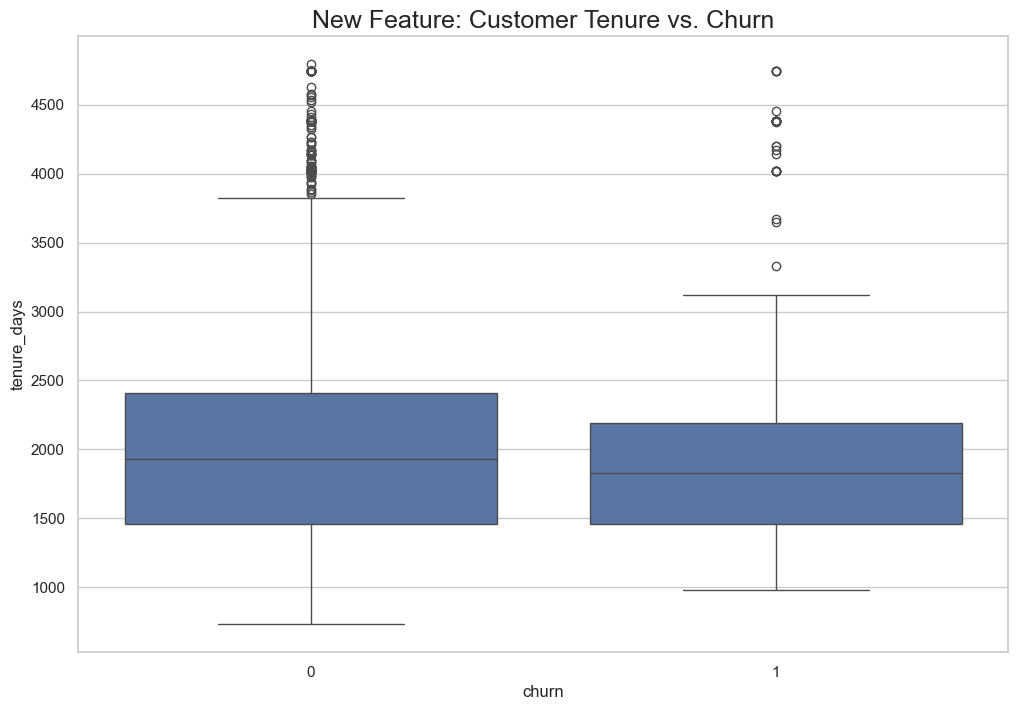

Plot saved to: plots\analysis_volatility_vs_churn.png


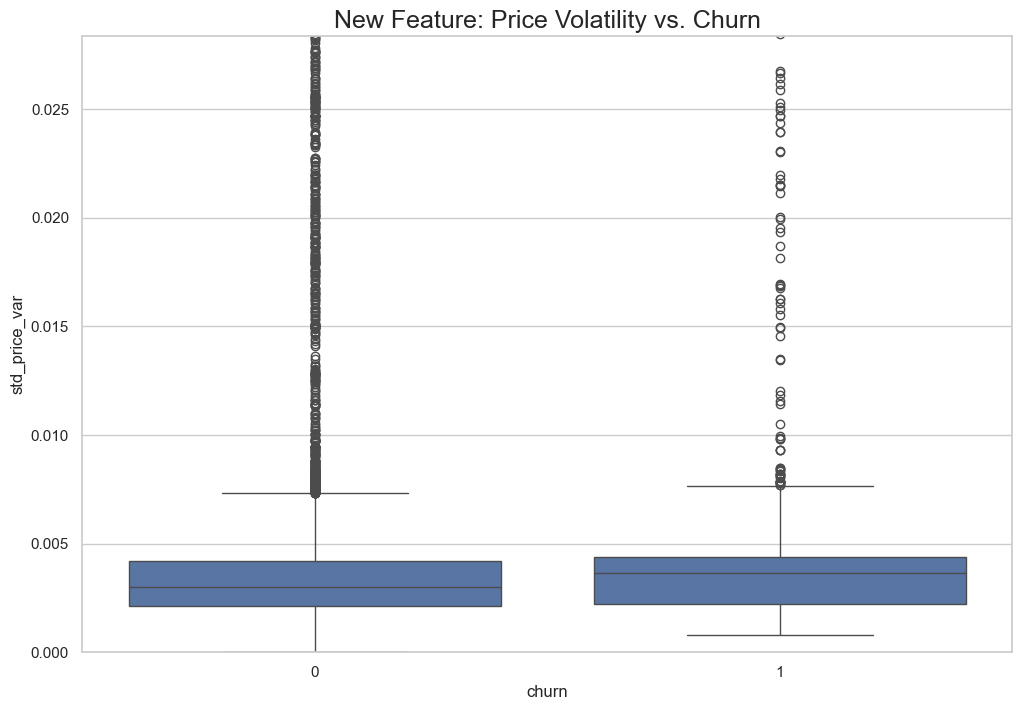

In [14]:
# --- Tenure vs. Churn ---
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x=config.TARGET_COL, y='tenure_days', data=after_df, ax=ax)
ax.set_title('New Feature: Customer Tenure vs. Churn', fontsize=18)
save_and_display_plot(fig, "analysis_tenure_vs_churn.png", config.PLOTS_DIR)

# --- Price Volatility vs. Churn ---
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x=config.TARGET_COL, y='std_price_var', data=after_df, ax=ax)
ax.set_title('New Feature: Price Volatility vs. Churn', fontsize=18)
ax.set_ylim(0, after_df['std_price_var'].quantile(0.99)) # Zoom in
save_and_display_plot(fig, "analysis_volatility_vs_churn.png", config.PLOTS_DIR)

## Step 9: Save Final Dataset

### Action:
- Saved the feature-engineered dataset to:  
  `output/features_for_modeling.csv`

### Stats:
- Final dataset ready with cleaned, encoded, and engineered features for predictive modeling  
- Shape: `(rows, columns)` = *(depends on data, displayed at runtime)*

---

In [15]:
# Save the final dataframe
output_path = os.path.join(config.OUTPUT_DIR, config.OUTPUT_DATA)
after_df.to_csv(output_path)

print(f"\nFeature-engineered dataset with {after_df.shape[1]} features saved to: {output_path}")


Feature-engineered dataset with 54 features saved to: output\features_for_modeling.csv


## Summary

This feature engineering pipeline has produced a modeling-ready dataset by combining time-based, price-based, and behavioral signals.

**Next Steps:**
- Train classification models (e.g., Logistic Regression, Random Forest)
- Handle class imbalance using SMOTE or stratified sampling
- Perform model evaluation with AUC-ROC, precision, recall, and SHAP for feature explainability

---